In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Use-Case")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Use-Case]


## Plan-and-Execute

`Plan-and-Execute`는 어떤 작업을 수행할때 계획을 먼저 세우고 실행하는 것을 의미합니다.   
복잡한 테스크를 Agent 에게 전달할때 Planner 가 계획을 먼저 세우게 됩니다.  
그 다음 순차적으로 Agent 에게 테스크와 계획을 전달하고 Planner 가 세운 계획대로 Agent 가 액션을 취하게 됩니다.  
그 다음 replan 에서 계획대로 실행할 수 있게 순차진행 하게됩니다.  
  
`Plan-and-Execute`는 다음과 같은 특징을 같습니다:  

- 장기 계획 수립: 복잡한 작업을 수행하기 전에 큰 그림을 그리는 장기 계획을 수립합니다.
- 단계별 실행 및 재계획: 세운 계획을 단계별로 실행하고, 각 단계가 완료될 때마다 계획이 여전히 유효한지 검토한 뒤 수정할 수 있습니다.

이 방식은 Plan-and-Solve 논문과 Baby-AGI 프로젝트에서 영감을 받았습니다.   
전통적인 ReAct 스타일의 에이전트는 한 번에 한 단계씩 생각하는 반면, `plan-and-execute` 는 명시적이고 장기적인 계획을 강조합니다.

##### 참고자료

- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)
- [Plan-and-Solve 논문](https://arxiv.org/abs/2305.04091)
- [Baby-AGI 프로젝트](https://github.com/yoheinakajima/babyagi)
- [ReAct 논문](https://arxiv.org/abs/2210.03629)

##### 그래프 흐름

![plan_and_execute](./assets/langgraph_use_case_plan_and_execute.png)

### 기능 구현

#### 모델 정의

In [4]:
from models import get_model_name, LLMs

# 모델명 정의
MODEL_NAME = get_model_name(LLMs.GPT4o_MINI)
print(MODEL_NAME)

gpt-4o-mini



#### 웹 검색 도구 정의

In [7]:
# 웹 검색 도구 초기화
from tools_tavily import TavilySearch

# 최대 검색 결과를 3으로 설정
web_search_tool = TavilySearch(max_results=3)

tools = [web_search_tool]

#### 작업 실행 에이전트 정의

In [8]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)


# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# ReAct 에이전트 생성
# llm: 생각하고 말하는 뇌
# tools: 문제 해결에 필요한 도구들(계산기, 검색기 등)
# state_modifier: LLM이 어떤 역할을 할지 정해주는 지침
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

In [9]:
# 에이전트 실행
agent_executor.invoke(
    {"messages": [("user", "랭체인 한국어 튜토리얼에 대해서 설명해줘")]}
)

{'messages': [HumanMessage(content='랭체인 한국어 튜토리얼에 대해서 설명해줘', additional_kwargs={}, response_metadata={}, id='b5f655d3-1184-4f1e-8eea-739588717887'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pbBbhU73b4fX7fvRmXmT0Wpz', 'function': {'arguments': '{"query":"랭체인 한국어 튜토리얼"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 155, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5adb9abd-714e-4dd1-8970-42b080bccd02-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭체인 한국어 튜토리얼'}, 'id': 'call_pbBbhU73b4fX7fvRmXmT0Wpz', 'type': 'tool_call'}], usa

#### 상태 정의

In [10]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


# 상태 정의
class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]
    plan: Annotated[List[str], "Current plan"]
    past_steps: Annotated[List[Tuple], operator.add]
    response: Annotated[str, "Final response"]

#### 계획(Planner) 생성

In [11]:
from pydantic import BaseModel, Field
from typing import List


# Plan 모델 정의
class Plan(BaseModel):
    """Sorted steps to execute the plan"""

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]

In [12]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
Answer in Korean.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Plan)

planner 동작을 확인합니다.

In [13]:
# Planner 실행
planner.invoke(
    {
        "messages": [
            (
                "user",
                "LangGraph 의 핵심 장단점과 LangGraph 를 사용하는 이유는 무엇인가?",
            )
        ]
    }
)

Plan(steps=['LangGraph의 정의와 기능을 이해한다.', 'LangGraph의 핵심 장점을 정리한다.', 'LangGraph의 핵심 단점을 정리한다.', 'LangGraph를 사용하는 이유를 정리한다.'])

#### Re-Plan 생성

이전 단계의 결과를 바탕으로 계획을 다시 수립하는 단계를 생성합니다.

In [14]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    # 사용자 응답
    response: str


class Act(BaseModel):
    """Action to perform."""

    # 수행할 작업: "Response", "Plan". 사용자에게 응답할 경우 Response 사용, 추가 도구 사용이 필요할 경우 Plan 사용
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Answer in Korean."""
)


# Replanner 생성
replanner = replanner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Act)

### 그래프 정의

#### 1. 노드 정의

In [15]:
from langchain_core.output_parsers import StrOutputParser


# 사용자 입력을 기반으로 계획을 생성하고 반환
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    # 생성된 계획의 단계 리스트 반환
    return {"plan": plan.steps}


# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    plan = state["plan"]
    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    # 현재 실행할 작업을 포맷팅하여 에이전트에 전달
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})
    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    # 응답이 사용자에게 반환될 경우
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    # 추가 단계가 필요할 경우 계획의 단계 리스트 반환
    else:
        next_plan = output.action.steps
        if len(next_plan) == 0:
            return {"response": "No more steps needed."}
        else:
            return {"plan": next_plan}


# 에이전트의 실행 종료 여부를 결정하는 함수
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "final_report"
    else:
        return "execute"


final_report_prompt = ChatPromptTemplate.from_template(
    """You are given the objective and the previously done steps. Your task is to generate a final report in markdown format.
Final report should be written in professional tone.

Your objective was this:

{input}

Your previously done steps(question and answer pairs):

{past_steps}

Generate a final report in markdown format. Write your response in Korean."""
)

final_report = (
    final_report_prompt
    | ChatOpenAI(model=MODEL_NAME, temperature=0)
    | StrOutputParser()
)


def generate_final_report(state: PlanExecute):
    past_steps = "\n\n".join(
        [
            f"Question: {past_step[0]}\n\nAnswer: {past_step[1]}\n\n####"
            for past_step in state["past_steps"]
        ]
    )
    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})
    return {"response": response}

#### 2. 엣지 설정 및 그래프 컴파일

In [16]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)
workflow.add_node("execute", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_node("final_report", generate_final_report)

# 엣지 정의
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "execute")
workflow.add_edge("execute", "replan")
workflow.add_edge("final_report", END)

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

#### 그래프 시각화

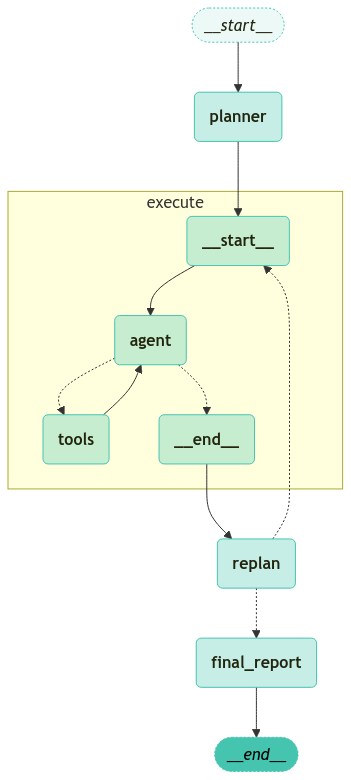

In [17]:
from graphs import visualize_graph

visualize_graph(app, xray=True)

#### 4. 실행

In [19]:
from langchain_print import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점을 설명해줘"
}

invoke_graph(app, inputs, config)


🔄 Node: planner 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Modular RAG와 Naive RAG의 정의를 이해한다.
Modular RAG의 구조와 작동 방식을 설명한다.
Naive RAG의 구조와 작동 방식을 설명한다.
Modular RAG와 Naive RAG의 주요 차이점을 비교한다.
Modular RAG가 production level에서 사용하는 이점을 정리한다.

🔄 Node: agent in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_HpjQrkPE57l4zIlBU1xsMrNX)
 Call ID: call_HpjQrkPE57l4zIlBU1xsMrNX
  Args:
    query: Modular RAG 정의
  tavily_web_search (call_OPnEgdxWxdjJiT0XsGSmTQa0)
 Call ID: call_OPnEgdxWxdjJiT0XsGSmTQa0
  Args:
    query: Naive RAG 정의

🔄 Node: tools in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Modular RAG", "url": "https://jjaegii.tistory.com/42", "content": "Modular RAG Modular RAG Modular RAG 모듈 독립적인 모듈 구성 Modular RAG 동

In [20]:
snapshot = app.get_state(config).values
print(snapshot["response"])

# 최종 보고서: Modular RAG와 Naive RAG의 비교 및 프로덕션 레벨에서의 이점

## 1. 서론
본 보고서는 Modular RAG(모듈형 RAG)와 Naive RAG(단순 RAG)의 정의, 구조, 작동 방식, 주요 차이점 및 Modular RAG가 프로덕션 레벨에서 제공하는 이점을 설명합니다. 이를 통해 두 시스템의 특성과 Modular RAG의 장점을 명확히 이해할 수 있습니다.

## 2. RAG의 정의

### 2.1 Modular RAG
- **정의**: Modular RAG는 RAG 시스템을 모듈화하여 유연성과 확장성을 높인 구조입니다. 각 모듈은 독립적으로 작동하며, 다양한 데이터 소스와 기술을 결합하여 최적의 결과를 도출합니다.
- **특징**:
  - **모듈화**: 다양한 모듈을 조합하여 시스템을 구성할 수 있습니다.
  - **유연성**: 필요에 따라 모듈을 추가하거나 변경할 수 있습니다.
  - **병렬 처리**: 여러 하위 모듈을 동시에 실행하고 결과를 병합할 수 있습니다.

### 2.2 Naive RAG
- **정의**: Naive RAG는 사용자의 쿼리에 대해 외부 지식 소스에서 관련 정보를 검색하고 이를 LLM에 전달하여 응답을 생성하는 방식입니다.
- **특징**:
  - **단순성**: 구현이 간단하고 직관적입니다.
  - **정보 검색**: 사용자의 쿼리를 기반으로 외부 데이터베이스에서 관련 정보를 검색합니다.
  - **응답 생성**: 검색된 정보를 바탕으로 LLM이 응답을 생성합니다.

## 3. 구조 및 작동 방식

### 3.1 Modular RAG의 구조 및 작동 방식
- **구조**:
  1. **모듈화된 구성 요소**: 정보 검색 모듈과 생성 모듈로 구성됩니다.
  2. **데이터 흐름**: 사용자가 질문을 입력하면 정보 검색 모듈이 관련 데이터를 검색하고, 이 데이터를 생성 모듈에 전달하여 최종 응답을 생성합니다.

- **작동 방식**:
  1. 쿼리 입력
  2. 정보 검색
  3. 정보 필터

In [21]:
from IPython.display import Markdown

Markdown(snapshot["response"])

# 최종 보고서: Modular RAG와 Naive RAG의 비교 및 프로덕션 레벨에서의 이점

## 1. 서론
본 보고서는 Modular RAG(모듈형 RAG)와 Naive RAG(단순 RAG)의 정의, 구조, 작동 방식, 주요 차이점 및 Modular RAG가 프로덕션 레벨에서 제공하는 이점을 설명합니다. 이를 통해 두 시스템의 특성과 Modular RAG의 장점을 명확히 이해할 수 있습니다.

## 2. RAG의 정의

### 2.1 Modular RAG
- **정의**: Modular RAG는 RAG 시스템을 모듈화하여 유연성과 확장성을 높인 구조입니다. 각 모듈은 독립적으로 작동하며, 다양한 데이터 소스와 기술을 결합하여 최적의 결과를 도출합니다.
- **특징**:
  - **모듈화**: 다양한 모듈을 조합하여 시스템을 구성할 수 있습니다.
  - **유연성**: 필요에 따라 모듈을 추가하거나 변경할 수 있습니다.
  - **병렬 처리**: 여러 하위 모듈을 동시에 실행하고 결과를 병합할 수 있습니다.

### 2.2 Naive RAG
- **정의**: Naive RAG는 사용자의 쿼리에 대해 외부 지식 소스에서 관련 정보를 검색하고 이를 LLM에 전달하여 응답을 생성하는 방식입니다.
- **특징**:
  - **단순성**: 구현이 간단하고 직관적입니다.
  - **정보 검색**: 사용자의 쿼리를 기반으로 외부 데이터베이스에서 관련 정보를 검색합니다.
  - **응답 생성**: 검색된 정보를 바탕으로 LLM이 응답을 생성합니다.

## 3. 구조 및 작동 방식

### 3.1 Modular RAG의 구조 및 작동 방식
- **구조**:
  1. **모듈화된 구성 요소**: 정보 검색 모듈과 생성 모듈로 구성됩니다.
  2. **데이터 흐름**: 사용자가 질문을 입력하면 정보 검색 모듈이 관련 데이터를 검색하고, 이 데이터를 생성 모듈에 전달하여 최종 응답을 생성합니다.

- **작동 방식**:
  1. 쿼리 입력
  2. 정보 검색
  3. 정보 필터링
  4. 응답 생성
  5. 결과 출력

### 3.2 Naive RAG의 구조 및 작동 방식
- **구조**:
  1. 질문 입력
  2. 정보 검색
  3. 문서 선택
  4. 생성 모델

- **작동 방식**:
  - 검색 단계와 생성 단계로 나뉘며, 전통적인 정보 검색 기법을 사용하여 관련 문서를 검색하고, 이를 바탕으로 답변을 생성합니다.

## 4. 주요 차이점 비교

1. **구조적 유연성**: Modular RAG는 모듈화된 구조로 유연성과 확장성을 제공하며, Naive RAG는 고정된 구조로 한계가 있습니다.
2. **모듈화**: Modular RAG는 각 모듈이 특정 역할을 담당하여 다양한 작업을 처리할 수 있지만, Naive RAG는 단일 흐름으로 진행됩니다.
3. **성능 최적화**: Modular RAG는 각 모듈을 독립적으로 최적화할 수 있어 성능 개선이 용이합니다.
4. **적응성**: Modular RAG는 다양한 시나리오에 맞춰 빠르게 적응할 수 있는 반면, Naive RAG는 적응성이 부족합니다.

## 5. Modular RAG의 프로덕션 레벨 이점

1. **유연성**: 다양한 모듈로 구성되어 있어 시스템을 조정할 수 있는 능력을 제공합니다.
2. **확장성**: 새로운 모듈이나 기능을 쉽게 추가하거나 교체할 수 있습니다.
3. **효율성**: 각 모듈이 특정 작업에 최적화되어 전체 시스템의 성능을 향상시킵니다.
4. **개선된 정확성**: 다양한 데이터 소스를 통합하여 더 정확하고 관련성 높은 결과를 생성할 수 있습니다.
5. **모듈화된 설계**: 특정 모듈에 문제가 발생하더라도 전체 시스템에 미치는 영향을 최소화할 수 있습니다.
6. **적응성**: 변화하는 환경에 빠르게 적응할 수 있습니다.

## 6. 결론
Modular RAG는 Naive RAG의 한계를 극복하고, 더 나은 성능과 유연성을 제공하는 정보 검색 및 생성 시스템입니다. 이러한 특성 덕분에 Modular RAG는 다양한 AI 응용 프로그램에 적합한 솔루션으로 자리잡고 있습니다.

In [22]:
print(snapshot["response"])

# 최종 보고서: Modular RAG와 Naive RAG의 비교 및 프로덕션 레벨에서의 이점

## 1. 서론
본 보고서는 Modular RAG(모듈형 RAG)와 Naive RAG(단순 RAG)의 정의, 구조, 작동 방식, 주요 차이점 및 Modular RAG가 프로덕션 레벨에서 제공하는 이점을 설명합니다. 이를 통해 두 시스템의 특성과 Modular RAG의 장점을 명확히 이해할 수 있습니다.

## 2. RAG의 정의

### 2.1 Modular RAG
- **정의**: Modular RAG는 RAG 시스템을 모듈화하여 유연성과 확장성을 높인 구조입니다. 각 모듈은 독립적으로 작동하며, 다양한 데이터 소스와 기술을 결합하여 최적의 결과를 도출합니다.
- **특징**:
  - **모듈화**: 다양한 모듈을 조합하여 시스템을 구성할 수 있습니다.
  - **유연성**: 필요에 따라 모듈을 추가하거나 변경할 수 있습니다.
  - **병렬 처리**: 여러 하위 모듈을 동시에 실행하고 결과를 병합할 수 있습니다.

### 2.2 Naive RAG
- **정의**: Naive RAG는 사용자의 쿼리에 대해 외부 지식 소스에서 관련 정보를 검색하고 이를 LLM에 전달하여 응답을 생성하는 방식입니다.
- **특징**:
  - **단순성**: 구현이 간단하고 직관적입니다.
  - **정보 검색**: 사용자의 쿼리를 기반으로 외부 데이터베이스에서 관련 정보를 검색합니다.
  - **응답 생성**: 검색된 정보를 바탕으로 LLM이 응답을 생성합니다.

## 3. 구조 및 작동 방식

### 3.1 Modular RAG의 구조 및 작동 방식
- **구조**:
  1. **모듈화된 구성 요소**: 정보 검색 모듈과 생성 모듈로 구성됩니다.
  2. **데이터 흐름**: 사용자가 질문을 입력하면 정보 검색 모듈이 관련 데이터를 검색하고, 이 데이터를 생성 모듈에 전달하여 최종 응답을 생성합니다.

- **작동 방식**:
  1. 쿼리 입력
  2. 정보 검색
  3. 정보 필터